<a href="https://colab.research.google.com/github/ekagra-ranjan/Auto-SCMA/blob/main/AWGN_Fast_DiffSCMA_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, random
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
from torch.optim.lr_scheduler import ReduceLROnPlateau
import itertools
import math
from time import time

torch.autograd.set_detect_anomaly(True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("\nDevice:", device)

seed = 6789 # also 0, 6789
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device is not "cpu":
    torch.cuda.manual_seed_all(seed)
    torch.cuda.set_rng_state(torch.cuda.get_rng_state())
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

eps = 1e-8

def pdb():
    import pdb; pdb.set_trace()


Device: cuda:0


In [ ]:
# Number of symbols
M = 4
# Number of users
J = 6
# Number of orthogonal resources
K = 4
# sparse mapping matrix V: K x J
V = torch.tensor([[0, 1, 1, 0, 1, 0],
                  [1, 0, 1, 0, 0, 1],
                  [0, 1, 0, 1, 0, 1],
                  [1, 0, 0, 1, 1, 0]
                ], dtype = torch.int32, device=device)

In [ ]:
def get_codebook_from_condensed_codebook():
    codebook = torch.zeros(J, M, K, 2).float().to(device)
    for i in range(J):
        resource_idx = (V[:, i]==1)
        codebook[i, :, resource_idx, :] = condensed_codebook[i] # [J, M, dv, 2]
    return codebook

In [ ]:
def encode(symbols, codebook, h=None):
    '''
    Inputs: symbols: [BS, J], h: [BS, J, 2*K], codebook: [J, M, K, 2],
    Returns [BS, 2*K]
    '''

    batch_size = symbols.shape[0]
    encoded = torch.zeros((batch_size, 2*K)).to(device)
    encoded_without_h = torch.zeros((batch_size, 2*K)).to(device)
    
    for user in range(J):
        # pdb()
        codeword = codebook[user][symbols[:, user]-1] # [BS, K, 2]
        codeword = codeword * V[:, user].reshape(1, -1, 1) # makes sure that codeword for resources not connected dont exist
        codeword = codeword.view(-1, 2*K) # [BS, 2*K]
        encoded_without_h = encoded_without_h + codeword
        codeword_faded = torch.zeros_like(codeword)
        
        if h is not None:
            '''CORRECT THE MULT WITH H'''
            real_idx = 2 * torch.arange(K).long()
            img_idx = 2 * torch.arange(K).long() + 1
            codeword_faded[:, real_idx] = codeword_faded[:, real_idx] + \
                                          (h[:, user, real_idx] * codeword[:, real_idx]) - \
                                          (h[:, user, img_idx] * codeword[:, img_idx])
            codeword_faded[:, img_idx]  = codeword_faded[:, img_idx] + \
                                          (h[:, user, real_idx] * codeword[:, img_idx]) + \
                                          (h[:, user, img_idx] * codeword[:, real_idx])
        else:
            codeword_faded = codeword_faded + codeword

        encoded = encoded + codeword_faded
    # pdb()
    return encoded, encoded_without_h

In [ ]:
def calc_distance(a, b):
    '''
    Args: a: [BS, 2]    b: [BS, M**df, 2]
    Returns: distance: [BS, M**df]
    '''
    # pdb()
    a = a.view(-1, 1, 2)
    return ((a-b)**2).sum(-1).squeeze(-1)




# def get_codebook_centre_resource(centres_all, x_centres_all, codebook, h, resource_id):
def get_codebook_centre_resource(codebook, h, resource_id):
    '''
    Inputs:
        codebook: [J, M, K, 2]
        h dim: [batch_size, J, 2*K]
        V: K x J

    Outputs:
        centres_all [BS, M**df, 2]: contains the real and img part of
                                    codewords for all permutation
                                    (i.e., M**df) of user symbols
                                    connected to kth resource,
                                    i.e., \sum_{j} h^{T}x_{j}
        x_centres_all [BS, M**df, 2*df]: contains the real and img part of
                                         each df users in codewords for all
                                         permutation (i.e., M**df) of user
                                         symbols connected to kth resource, x_{j}
    '''
    centres_all = torch.zeros((h.shape[0], M**df, 2), device=device)        # [BS, M**df, 2]
    x_centres_all = torch.zeros((M**df, 2*df), device=device)               # [M**sd, 2*df]
            

    #---Create centres_all
    t1 = time()
    resource_user_idx = V[resource_id].nonzero().reshape(-1)
    alphabets = np.arange(1, M+1)
    symbols_resource = [torch.tensor(p) for p in itertools.product(alphabets, repeat=df)] 
    symbols_resource = torch.stack(symbols_resource).to(device)             # [M**df, df]

    symbols_resource.unsqueeze_(0)                                          # [1, M**df, df]
    symbols_resource = symbols_resource.repeat(h.shape[0], 1, 1)            # [BS, M**df, df]
    
    symbols_resource_all = torch.zeros((M**df, J),\
                                        dtype = torch.int64, device=device) # [M**df, J]
    symbols_resource_all[:, resource_user_idx] = symbols_resource[0]        # [M**df, J]
    
    h_repeat_perm = h.unsqueeze(1).repeat(1, M**df, 1, 1)                   # [BS, M**df, J, 2*K]
    h_repeat_perm = h_repeat_perm.view(-1, J, 2*K)                          # [BS * M**df, J, 2*K]
    
     
    symbols_resource = symbols_resource.view(-1, df)                        # [BS * M**df, df]
    codeword_faded_k = torch.zeros((symbols_resource.shape[0], 2), device=device)
    for user_idx, user in enumerate(resource_user_idx):
        # pdb()
        codeword = codebook[user][symbols_resource[:, user_idx]-1]          # [BS, K, 2]
        codeword_k = codeword[:, resource_id, :]                            # [BS, 2]
        codeword_k = codeword_k * V[resource_id, user] # makes sure that codeword for resources not connected dont exist
        
        '''CORRECT THE MULT WITH H'''
        real_idx = 2 * resource_id
        img_idx = 2 * resource_id + 1
        codeword_faded_k[:, 0] = codeword_faded_k[:, 0] + \
                                        (h_repeat_perm[:, user, real_idx] * codeword_k[:, 0]) - \
                                        (h_repeat_perm[:, user, img_idx] * codeword_k[:, 1])
        codeword_faded_k[:, 1]  = codeword_faded_k[:, 1] + \
                                        (h_repeat_perm[:, user, real_idx] * codeword_k[:, 1]) + \
                                        (h_repeat_perm[:, user, img_idx] * codeword_k[:, 0])
    
    centres_all[:, :, :] = codeword_faded_k.view(h.shape[0], M**df, 2) 
    # print('1 Time:', time()-t1)
    

    # ---Create x_centres_all
    t1 = time()
    symbols_resource_all = symbols_resource_all.unsqueeze(1).repeat(1, df, 1) # [M**df, df, J]
    symbols_resource_all = symbols_resource_all.view(-1, J)                 # [M**df * df, J]
    h_x = torch.zeros((df, J, 2*K), device=device)                          # [df, J, 2*K]
    real_idx = 2 * torch.arange(K).long()
    temp = torch.zeros((2*K), device=device)
    temp[real_idx] = 1.0
    
    for idx, val in enumerate(V[resource_id].nonzero().reshape(-1)):
        h_x[idx, val, :] = temp
    
    h_x = h_x.view(1, df, J, 2*K)
    h_x = h_x.repeat(M**df, 1, 1, 1)                                        # [M**df, df, J, 2*K]
    h_x = h_x.view(-1, J, 2*K)
    x_centres, _ = encode(symbols_resource_all, codebook, h=h_x)            # [M**df * df, 2*K]
    x_centres = x_centres.view(M**df, df,2*K)\
                [:, :, 2 * resource_id: 2 * resource_id + 2]                # [M**df, df, 2]
    x_centres = x_centres.reshape(M**df, 2 * df)
    x_centres_all[:, :] = x_centres
    # print('2 Time:', time()-t1)
    
    return centres_all, x_centres_all

In [ ]:
df = (V[0]==1).sum() # num of users connected to kth resource
dv = (V.t()[0]==1).sum() # num of resources connected to jth user


class MPA():

    def __init__(self):
        alphabets = np.arange(1, M+1)
        self.symbols_resource = [torch.tensor(p) for p in itertools.product(alphabets, repeat=df)] 
        self.symbols_resource = torch.stack(self.symbols_resource).to(device)   # [M**df, df]
        self.symbols_resource.unsqueeze_(0)                                     # [1, M**df, df]


    def calc_distance(self, a, b):
        '''
        Args: a: [BS, 2]    b: [BS, M**df, 2]
        Returns: distance: [BS, M**df]
        '''
        # pdb()
        a = a.view(-1, 1, 2)
        return ((a-b)**2).sum(-1).squeeze(-1)




    # def get_codebook_centre_resource(centres_all, x_centres_all, codebook, h, resource_id):
    def get_codebook_centre_resource(self, codebook, h, resource_id):
        '''
        Inputs:
            codebook: [J, M, K, 2]
            h dim: [batch_size, J, 2*K]
            V: K x J

        Outputs:
            centres [BS, M**df, 2]: contains the real and img part of
                                        codewords for all permutation
                                        (i.e., M**df) of user symbols
                                        connected to kth resource,
                                        i.e., \sum_{j} h^{T}x_{j}
            x_centres [BS, M**df, 2*df]: contains the real and img part of
                                            each df users in codewords for all
                                            permutation (i.e., M**df) of user
                                            symbols connected to kth resource, x_{j}
        '''
        
        #---Create centres_all
        t1 = time()
        resource_user_idx = V[resource_id].nonzero().reshape(-1)
        symbols_resource = self.symbols_resource.repeat(h.shape[0], 1, 1)            # [BS, M**df, df]
        
        symbols_resource_all = torch.zeros((M**df, J),\
                                            dtype = torch.int64, device=device) # [M**df, J]
        symbols_resource_all[:, resource_user_idx] = symbols_resource[0]        # [M**df, J]
        
        h_repeat_perm = h.unsqueeze(1).repeat(1, M**df, 1, 1)                   # [BS, M**df, J, 2*K]
        h_repeat_perm = h_repeat_perm.view(-1, J, 2*K)                          # [BS * M**df, J, 2*K]
        
        
        symbols_resource = symbols_resource.view(-1, df)                        # [BS * M**df, df]
        codeword_faded_k = torch.zeros((symbols_resource.shape[0], 2), device=device)
        for user_idx, user in enumerate(resource_user_idx):
            # pdb()
            codeword = codebook[user][symbols_resource[:, user_idx]-1]          # [BS, K, 2]
            codeword_k = codeword[:, resource_id, :]                            # [BS, 2]
            codeword_k = codeword_k * V[resource_id, user] # makes sure that codeword for resources not connected dont exist
            
            '''CORRECT THE MULT WITH H'''
            real_idx = 2 * resource_id
            img_idx = 2 * resource_id + 1
            codeword_faded_k[:, 0] = codeword_faded_k[:, 0] + \
                                            (h_repeat_perm[:, user, real_idx] * codeword_k[:, 0]) - \
                                            (h_repeat_perm[:, user, img_idx] * codeword_k[:, 1])
            codeword_faded_k[:, 1]  = codeword_faded_k[:, 1] + \
                                            (h_repeat_perm[:, user, real_idx] * codeword_k[:, 1]) + \
                                            (h_repeat_perm[:, user, img_idx] * codeword_k[:, 0])
        
        # ---Create x_centres_all
        t1 = time()
        symbols_resource_all = symbols_resource_all.unsqueeze(1).repeat(1, df, 1) # [M**df, df, J]
        symbols_resource_all = symbols_resource_all.view(-1, J)                 # [M**df * df, J]
        h_x = torch.zeros((df, J, 2*K), device=device)                          # [df, J, 2*K]
        real_idx = 2 * torch.arange(K).long()
        temp = torch.zeros((2*K), device=device)
        temp[real_idx] = 1.0
        
        for idx, val in enumerate(V[resource_id].nonzero().reshape(-1)):
            h_x[idx, val, :] = temp
        
        h_x = h_x.view(1, df, J, 2*K)
        h_x = h_x.repeat(M**df, 1, 1, 1)                                        # [M**df, df, J, 2*K]
        h_x = h_x.view(-1, J, 2*K)
        x_centres, _ = encode(symbols_resource_all, codebook, h=h_x)            # [M**df * df, 2*K]
        x_centres = x_centres.view(M**df, df,2*K)\
                    [:, :, 2 * resource_id: 2 * resource_id + 2]                # [M**df, df, 2]
        x_centres = x_centres.reshape(M**df, 2 * df)
        
        return codeword_faded_k.view(h.shape[0], M**df, 2), x_centres


    def resource_to_user(self, x, u2r, codebook, h, sigma_square, beta):
        '''
        Inputs:  x: [BS, 2*K] , i.e., received signal, u2r: [BS, J, K, M], h: [BS, J, 2*K]
        Output: [BS, K, J, M]
        '''

        message_all = torch.zeros((h.shape[0], K, J, M), device=device)
        
        for i in range(0, K):
            # pdb()
            '''
            centres_all: [batch_size, M**df, 2]
            x_centres_all: [BS, M**df, 2*df]
            '''
            t1 = time()
            centres = self.centres_all[i]
            x_centres = self.x_centres_all[i]
            x_centres = x_centres.view(1, M**df, df, 2) # [1, M**df, df, 2]

            distance = self.calc_distance(x[:, 2*i:2*i+2], centres) # distance([BS, 2], [BS, M**df, 2]) -> [BS, M**df]
            distance = - (1.0/(2.0 * sigma_square)) * distance
            assert distance.dtype == torch.float32, "distance is not float32"
            M_k = torch.zeros((h.shape[0], J, M), device=device) # conditional prob of x_{j} given r_{k}

            u2r_ = u2r.permute(0, 2, 1, 3) # [BS, K, J, M]


            '''Check from here'''
            u2r_resource = u2r_[:, i, V[i]==1] # [BS, df, M]
            prior_big = torch.zeros((h.shape[0], M**df, df), device=device) # [BS, M**df, df]

            t1 = time()
            for df_idx in range(df):
                
                u2r_resource_df = u2r_resource[:, df_idx, :] # [BS, M]
                u2r_resource_df = u2r_resource_df.reshape(1, -1) # [1, BS * M]
                symbols_resource_df = (self.symbols_resource[:, :, df_idx] - 1).repeat(h.shape[0], 1) # [BS, M**df]
                incrementor = torch.arange(0, M * h.shape[0], M).view(-1, 1).to(device) # [BS, 1]
                symbols_resource_df_mask = symbols_resource_df + incrementor # [BS, M**df]
                symbols_resource_df_mask = symbols_resource_df_mask.view(1, -1) # [1, BS * M**df]
                prior_big_df = u2r_resource_df[0, symbols_resource_df_mask] # [1, BS * M**df]
                prior_big_df = prior_big_df.view(-1, M**df) # [BS, M**df]
                prior_big[:, :, df_idx] = prior_big_df # [BS, M**df, df]

            prior_big_sum = prior_big.sum(-1) # [BS, M**df]
            
            user_idx = (V[i]).nonzero().reshape(-1)
            # print('Time df', time()-t1)
            t1 = time()
            for idx, j in enumerate(user_idx):
                # pdb()
                
                '''Careful: codebook is [J, M, K, 2] which is numpy'''
                df_unique = codebook[j, :, i, :] # [M, 2]
                x_centres_temp = x_centres[:, :, idx] # [1, M**df, 2]
                assert df_unique.dtype == x_centres_temp.dtype, "comparison vars dont have same dtype for mask_temp"


                # pdb()
                mask_temp = (df_unique.view(1, M, 1, 2) == x_centres_temp.view(1, 1, M**df, 2)) # [1, M, M**df, 2]
                mask = (mask_temp.sum(-1)==2) # [1, M, M**df]: for matching, both real and img parts will match hence 2.
                mask = mask.repeat(h.shape[0], 1, 1) # [BS, M, M**df]

                prior_big_m = prior_big_sum - prior_big[:, :, idx] # [BS, M**df]
                message = distance + prior_big_m # [BS, M**df]
                lowest_message = message.min()

                message = message.unsqueeze(1).repeat(1, M, 1) # [BS, M, M**df]

                # pdb()
                message = torch.where(mask, message, lowest_message) # [BS, M, M**df]
                
                #---log-sum-MPA
                message_max = message.max(-1)[0] # [BS, M]: 0 is used to use take the max and not the indices
                message = message - message_max.view(-1, M, 1)
                message = torch.exp(message) # [BS, M, M**df]
                message = torch.where(mask, message, torch.tensor([0.0], device=device))
                message = message.sum(-1) # [BS, M]
                
                message = torch.log(message) # [BS, M]
                message = message + message_max # [BS, M]
                # pdb()
                
                #---Max log MPA
                # message = message.max(-1)[0] # [BS]: 0 is used to use take the max and not the indices
                
                message_all[:, i, j] = message + beta
            # print('Time user_idx', time()-t1)
                
        return message_all




    def user_to_resource(self, r2u, gamma):
        '''
        Input: r2u: [BS, K, J, M]
        Returns [BS, J, K, M]
        '''
        assert (r2u == float("-inf")).sum() == 0, "r2u has -inf values!" # if -inf, then need to implement the counting of -inf freq

        message_all = torch.zeros((r2u.shape[0], J, K, M), device=device)
        r2u_ = r2u.permute(0, 2, 1, 3) # [BS, J, K, M]
        # to filter out messages to those resources which are not onnected to the user
        mask = torch.where(r2u_!=0, torch.tensor([1.0], device=device), torch.tensor([0.0], device=device))

        # pdb()
        ''' Need to change'''
        message_all = -r2u_ # [BS, J, K, M]
        for i in range(J):
            message_all[:, i, :, :] = message_all[:, i, :, :] + r2u_[:, i].sum(-2).view(-1, 1, M) + gamma # [BS, 1, M]
        # pdb()
        message_all = mask * message_all
        
        #---normalisation

        Z = torch.exp(message_all)
        Z = torch.where(message_all!=0, Z, torch.tensor([torch.exp(-gamma) / M], device=device)) # [BS, J, K, M]
        Z = torch.log(Z.sum(-1))

        message_all = message_all - Z.view(-1, J, K, 1) # [BS, J, K, M]

        return message_all




    def calc_output(self, r2u):
        '''
        Input: r2u: [BS, K, J, M]
        Output: [BS, J, M]
        '''
        r2u_ = r2u.permute(0, 2, 3, 1) # [BS, J, M, K]
        return r2u_.sum(-1) + gamma



    def forward(self, x, codebook, h, sigma_square, beta, gamma):
        ''' 
        Inputs:
        x: [BS, 2*K] , i.e., received signal
        h: [BS, J, 2*K]

        Variables used:
        u2r [BS, J, K, M]: user to resource message
        r2u [BS, K, J, M]: resource to user message
        '''

        '''
            centres_all: [batch_size, M**df, 2]
            x_centres_all: [BS, M**df, 2*df]
        '''
        self.centres_all = torch.zeros((K, h.shape[0], M**df, 2), device=device)        # [K, BS, M**df, 2]
        self.x_centres_all = torch.zeros((K, M**df, 2*df), device=device)               # [K, M**sd, 2*df]

        t1 = time()
        for i in range(K):
            self.centres_all[i], self.x_centres_all[i] = self.get_codebook_centre_resource(codebook, h, i)
        # print('centres:', time()-t1)
        
        u2r = torch.zeros((x.shape[0], J, K, M), device=device) # Initialise u2r with 0
        u2r = u2r + gamma
        
        # pdb(True)
        t1 = time()
        r2u = self.resource_to_user(x, u2r, codebook, h, sigma_square, beta) # [BS, K, J, M]
        # print('0: r2u: ', time()-t1)
        u2r = self.user_to_resource(r2u, gamma) # [BS, J, K, M]
        t1=time()
        # print('0: u2r: ', time()-t1)

        for i in range(n_iter - 1):
            # pdb()
            t1=time()
            r2u = self.resource_to_user(x, u2r, codebook, h, sigma_square, beta) # [BS, K, J, M]
            # print(i, ': r2u: ', time()-t1)
            t1=time()
            u2r = self.user_to_resource(r2u, gamma) # [BS, J, K, M]
            # print(i, ': u2r: ', time()-t1)
        # pdb()
        t1=time()
        y = self.calc_output(r2u)
        # print('output: ', time()-t1)
        return y

In [ ]:
def add_noise(codewords, J, snr):
    '''
    codewords: [batch_size, 2*K]
    snr: scalar
    '''
    # pdb()
    batch_size = codewords.shape[0]
    Es = torch.mean(codewords**2) # per real value or img value
    Es_db = 10*torch.log10(Es)
    noise_db = Es_db - torch.as_tensor(snr).to(device)
    noise_power = 10**(noise_db/10)
    noise = torch.randn(batch_size, 2*K).to(device) * torch.sqrt(noise_power).to(device)
    output = codewords + noise

    # pdb()

    return noise, noise_power

In [ ]:
def compute_ber(symbols, decoded_symbols, M):
    '''
    Inputs: symbols, decoded_symbols: [BS*J]
    '''
    symbols_0 = symbols - 1
    decoded_symbols_0 = decoded_symbols - 1
    true = np.unpackbits(symbols_0.reshape(-1, 1).astype('uint8'), axis=1)[:, -int(np.log2(M)):] # [BS*J, log2(M)]
    predicted = np.unpackbits(decoded_symbols_0.reshape(-1, 1).astype('uint8'), axis=1)[:, -int(np.log2(M)):] # [BS*J, log2(M)]

    Nerr_check = (true!=predicted) # [BS*J, log2(M)]
    ber_batch = (true!=predicted).mean() # [1]
    
    Nerr_per_user = np.sum(Nerr_check, axis=-1) # [BS*J]
    Nerr_per_user = np.sum(Nerr_per_user.reshape(-1, J), axis=0) # [J]
    

    return ber_batch, Nerr_per_user

In [ ]:
batch_size = 1024

df = (V[0]==1).sum() # num of users connected to a resource (needs to be same for all resources)
dv = (V[:, 0]==1).sum() # num of resources connected to a user (needs to be same for all users)

#---Initialize the condensed_codebook
condensed_codebook = torch.randn((J, M, dv, 2), dtype = torch.float32, device = device, requires_grad = True)

#---Create MPA
mpa = MPA()

#---Create Optimizer and Loss Function
params = [condensed_codebook]

# optimizer = torch.optim.RMSprop(params, lr=1e-4, alpha=0.99, eps=1e-08, weight_decay=1e-5) # wt decay was 1e-5
optimizer = torch.optim.Adam(params, lr=1e-2, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
loss_func = torch.nn.CrossEntropyLoss()

scheduler = ReduceLROnPlateau(optimizer, factor = 0.5, patience = 150, mode = 'min')

In [ ]:
symbols = np.random.randint(1, M+1, (batch_size, J))
enc = OneHotEncoder(categories=np.stack(J*[range(1,M+1)]))
_ = enc.fit(symbols)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:76: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories != 'auto':
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:85: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categories == 'auto':


In [ ]:
is_fading = False
is_noise = True
print("Fading: ", is_fading, "  Noise: ", is_noise)

iterations = 500
n_iter = 3
maxNumErrs = 100 # min number of bits error to be seen before ending the run
maxNumBits = 1e7 # max number of bits per user to be processed

beta = 0 #+ np.log(1/(2* math.pi * sigma_square)**0.5)

Nerr_per_user = np.zeros([J])
Nbits = 0 # number of bits processed till now

for iteration in range(iterations):

    EbN = 6
    snr = EbN + 10*np.log10(np.log2(M)*J/K)

    # pdb()
    #---Get codebook
    codebook = get_codebook_from_condensed_codebook()

    #---Generate symbols and channel parameters
    if is_fading is True:
        h = (torch.randn(batch_size, J, 2*K)/torch.sqrt(torch.tensor(2.0))).to(device)
    else:
        h = torch.zeros(batch_size, J, 2*K).to(device)
        real_idx = 2 * torch.arange(K).long()
        h[:, :, real_idx] = 1.0

    symbols = np.random.randint(1, M+1, (batch_size, J))
    
    codewords_faded, codewords_faded_without_h = encode(symbols, codebook, h = h)    
    received_signal = codewords_faded
    
    '''noise is being calc using codewords_faded_without_h '''
    noise, sigma_square = add_noise(codewords_faded_without_h, J, snr)
    
    if is_noise is True:
        received_signal = received_signal + noise
    

    #---Decode
    beta = torch.log((1/(2* math.pi * sigma_square)**0.5))
    gamma = torch.log(torch.tensor((1.0/M), device=device, dtype=torch.float32)) # log(p_x{j})
    decoded_symbols_one_hot = mpa.forward(received_signal, codebook, h, sigma_square, beta, gamma)
    
    # pdb()

    # Backward pass
    target = torch.LongTensor(symbols.reshape(-1) - 1).to(device)
    loss = loss_func(decoded_symbols_one_hot.view(-1, M), target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # scheduler.step(loss)


    # Compute metrics
    decoded_symbols = torch.argmax(decoded_symbols_one_hot, dim=-1) + 1
    accuracy_batch = np.mean(symbols == decoded_symbols.cpu().data.numpy())
    ber_batch, Nerr_per_user_batch = compute_ber(symbols.reshape(batch_size*J), decoded_symbols.cpu().data.numpy().reshape(batch_size*J), M)
    
    Nerr_per_user += Nerr_per_user_batch
    Nbits += batch_size * np.log2(M)

    # if (iteration + 1) % 50 == 0:
    print('iter: ', iteration+1, '/', iterations, ' Acc_batch = {:.4f}'.format(accuracy_batch),
          ' SER_batch = {:.4f}'.format(1-accuracy_batch), ' BER_batch = {:.4f}'.format(ber_batch),
          ' loss: {:.3f}'.format(loss), ' lr: {:.4f}'.format(optimizer.param_groups[0]['lr']))
    
    

Fading:  False   Noise:  True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


iter:  1 / 500  Acc_batch = 0.8688  SER_batch = 0.1312  BER_batch = 0.0821  loss: 0.328  lr: 0.0100
iter:  2 / 500  Acc_batch = 0.8703  SER_batch = 0.1297  BER_batch = 0.0845  loss: 0.324  lr: 0.0100
iter:  3 / 500  Acc_batch = 0.8791  SER_batch = 0.1209  BER_batch = 0.0780  loss: 0.305  lr: 0.0100
iter:  4 / 500  Acc_batch = 0.8771  SER_batch = 0.1229  BER_batch = 0.0786  loss: 0.307  lr: 0.0100
iter:  5 / 500  Acc_batch = 0.8779  SER_batch = 0.1221  BER_batch = 0.0781  loss: 0.307  lr: 0.0100
iter:  6 / 500  Acc_batch = 0.8870  SER_batch = 0.1130  BER_batch = 0.0729  loss: 0.284  lr: 0.0100
iter:  7 / 500  Acc_batch = 0.8787  SER_batch = 0.1213  BER_batch = 0.0786  loss: 0.296  lr: 0.0100
iter:  8 / 500  Acc_batch = 0.8794  SER_batch = 0.1206  BER_batch = 0.0793  loss: 0.284  lr: 0.0100
iter:  9 / 500  Acc_batch = 0.8989  SER_batch = 0.1011  BER_batch = 0.0640  loss: 0.265  lr: 0.0100
iter:  10 / 500  Acc_batch = 0.8976  SER_batch = 0.1024  BER_batch = 0.0679  loss: 0.260  lr: 0.0100

In [ ]:
#---Testing
# is_fading = True
# is_noise  = True
EbN = np.arange(0, 15+1)

accuracy_all = np.zeros_like(EbN ,dtype=np.float64)
ber_all = np.zeros_like(EbN ,dtype=np.float64)
test_samples = 10000
steps = 10 # total_samples = step * test_samples

with torch.no_grad():
    for i, ebn in enumerate(EbN):

        Nerr_per_user_ebn = np.zeros([J])
        Nbits = 0 # number of bits processed till now
        accuracy_ebn = []
        wrong_symbols_ebn = []
        ber_ebn = []
        wrong_bits_ebn = []

        # steps = test_samples // 10000
        step = 1

        # while(step <= steps):
        while( (Nerr_per_user_ebn.min() < maxNumErrs) and (Nbits < maxNumBits) ):
        
            step = step + 1

            snr = ebn + 10*np.log10(np.log2(M)*J/K)

            codebook = get_codebook_from_condensed_codebook()

            #---Generate symbols and channel parameters
            symbols = np.random.randint(1, M+1, (test_samples, J))
            symbols_one_hot = torch.Tensor(enc.transform(symbols).toarray().reshape((test_samples, J, M))).to(device) # [test_samples, J, M]

            #---Fading
            if is_fading is True:
                h = (torch.randn(test_samples, J, 2*K)/torch.sqrt(torch.tensor(2.0))).to(device)
            else:
                h = torch.zeros(test_samples, J, 2*K).to(device)
                real_idx = 2 * torch.arange(K).long()
                h[:, :, real_idx] = 1.0
                
            #---Encode
            codewords_faded, codewords_faded_without_h = encode(symbols, codebook, h = h)    
            received_signal = codewords_faded
            
            #---Noise
            '''noise is being calc using codewords_faded_without_h '''
            noise, sigma_square = add_noise(codewords_faded_without_h, J, snr)
            
            if is_noise is True:
                received_signal = received_signal + noise
            

            #---Decode
            beta = torch.log((1/(2* math.pi * sigma_square)**0.5))
            gamma = torch.log(torch.tensor((1.0/M), device=device, dtype=torch.float32)) # log(p_x{j})
            decoded_symbols_one_hot = mpa.forward(received_signal, codebook, h, sigma_square, beta, gamma)
            
            
            #---Compute metrics
            decoded_symbols = torch.argmax(decoded_symbols_one_hot, dim=-1) + 1
            accuracy_batch = np.mean(symbols == decoded_symbols.cpu().data.numpy())
            wrong_symbols_batch = (symbols != decoded_symbols.cpu().data.numpy()).sum()
            ber_batch, Nerr_per_user = compute_ber(symbols.reshape(test_samples*J), decoded_symbols.cpu().data.numpy().reshape(test_samples*J), M)
            wrong_bits_batch = Nerr_per_user.sum()

            accuracy_ebn.append(accuracy_batch)
            wrong_symbols_ebn.append(wrong_symbols_batch)
            ber_ebn.append(ber_batch)
            wrong_bits_ebn.append(wrong_bits_batch)

            Nerr_per_user_ebn += Nerr_per_user
            Nbits += test_samples * np.log2(M)

        accuracy = np.array(accuracy_ebn).mean()
        wrong_symbols = np.array(wrong_symbols_ebn).sum()
        ber = np.array(ber_ebn).mean()
        wrong_bits = np.array(wrong_bits_ebn).sum()
        accuracy_all[i] = accuracy
        ber_all[i] = ber

        print("EbN:", ebn, ' Acc: {:.8f}'.format(accuracy),
            ' SER: {:.8f}'.format(1-accuracy),'BER: {:.8f}'.format(ber),
            ' Wrong Symbols: ', wrong_symbols, '/', test_samples*(step-1)*J,
            ' Wrong Bits: ', wrong_bits, '/', test_samples*(step-1)*J*np.log2(M))


EbN: 0  Acc: 0.73516667  SER: 0.26483333 BER: 0.17461667  Wrong Symbols:  15890 / 60000  Wrong Bits:  20954 / 120000.0
EbN: 1  Acc: 0.77595000  SER: 0.22405000 BER: 0.14719167  Wrong Symbols:  13443 / 60000  Wrong Bits:  17663 / 120000.0
EbN: 2  Acc: 0.82293333  SER: 0.17706667 BER: 0.11757500  Wrong Symbols:  10624 / 60000  Wrong Bits:  14109 / 120000.0
EbN: 3  Acc: 0.86551667  SER: 0.13448333 BER: 0.08934167  Wrong Symbols:  8069 / 60000  Wrong Bits:  10721 / 120000.0
EbN: 4  Acc: 0.90613333  SER: 0.09386667 BER: 0.06224167  Wrong Symbols:  5632 / 60000  Wrong Bits:  7469 / 120000.0
EbN: 5  Acc: 0.94210000  SER: 0.05790000 BER: 0.03847500  Wrong Symbols:  3474 / 60000  Wrong Bits:  4617 / 120000.0
EbN: 6  Acc: 0.96808333  SER: 0.03191667 BER: 0.02140000  Wrong Symbols:  1915 / 60000  Wrong Bits:  2568 / 120000.0
EbN: 7  Acc: 0.98503333  SER: 0.01496667 BER: 0.00989583  Wrong Symbols:  1796 / 120000  Wrong Bits:  2375 / 240000.0
EbN: 8  Acc: 0.99355833  SER: 0.00644167 BER: 0.00441042

In [ ]:
!nvidia-smi

Sun Oct 11 05:27:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    47W /  70W |   1221MiB / 15079MiB |     55%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

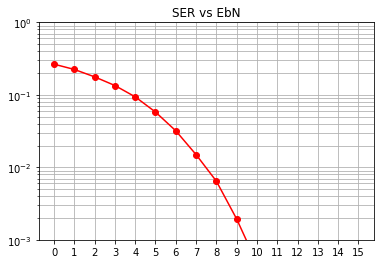

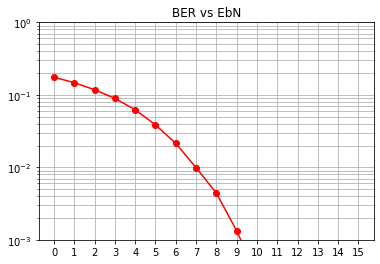

In [ ]:
#---Plot Metrics across different channels
ymin = 1e-3
ymax = 1e-0
xmin = EbN[0]
xmax = EbN[-1]


f1 = plt.figure()
f2 = plt.figure()

ax1 = f1.add_subplot(111)
ax1.set_title('SER vs EbN')
ax1.set_yscale('log')
ax1.set_ylim([ymin,ymax])
# ax1.set_xlim([xmin,xmax])
ax1.set_xticks(EbN)
ax1.grid(which="both")
ax1.plot(EbN, 1-accuracy_all, '-or')

ax2 = f2.add_subplot(111)
ax2.set_title('BER vs EbN')
ax2.set_yscale('log')
ax2.set_ylim([ymin,ymax])
# ax1.set_xlim([xmin,xmax])
ax2.set_xticks(EbN)
ax2.grid(which="both")
ax2.plot(EbN, ber_all, '-or')
plt.show()

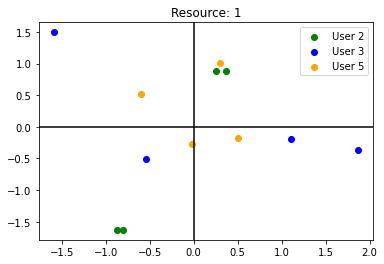

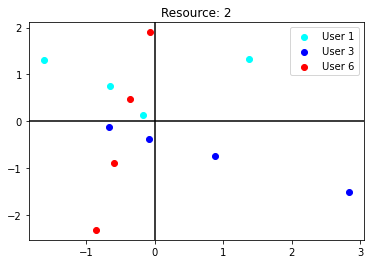

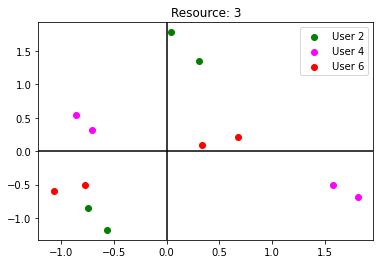

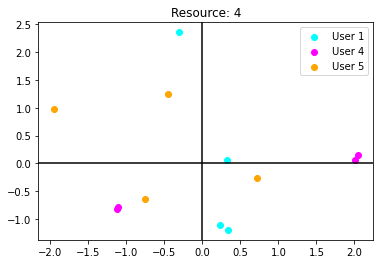

In [ ]:
#---See the learned Codebook
batch_size_plot = M
symbols = np.arange(M)+1
symbols = np.stack(J*[symbols], axis=0).transpose()

#---Get codebook
codebook = get_codebook_from_condensed_codebook()

h_all = []
real_idx = 2 * torch.arange(K).long()

for i in range(J):
  h = np.zeros([J, 2*K])
#   h[i, :] = np.ones([1, 2*K])
  h[i, real_idx] = 1.0
  h = np.stack(batch_size_plot*[h], axis = 0)
  h = torch.Tensor(h).to(device)
  h_all.append(h)


#---Forward Pass
codewords_faded_all = []
for i in range(J):
    codewords_faded, codewords_faded_without_h = encode(symbols, codebook, h = h_all[i])
    codewords_faded_all.append(codewords_faded)



import matplotlib.pyplot as plt
#---code for color assignment for arbitrary num of users
# user_colors = {}
# users = np.arange(J)
# unique_users = list(set(users)) 
# step_size = (256**3) // len(unique_users)
# for i, user in enumerate(unique_users):
#     temp = step_size*i
#     color = np.zeros([3], dtype=np.float32) # RGB
#     for pigment in range(3):
#       r = temp % 256
#       color[pigment] = r/256
#       temp = temp//256
#     user_colors[user] = color.tolist()
# colors = [user_colors[user] for user in users]

colors = ['cyan', 'green', 'blue', 'magenta', 'orange', 'red']

for k in range(K):
  fig, ax = plt.subplots()
  for user in range(J):
    data = codewords_faded_all[user].cpu().detach().numpy()
    if np.abs(data[:, 2*k]).sum()!=0:
      ax.scatter(data[:, 2*k], data[:, 2*k+1], c=colors[user], label='User '+str(user+1))

  ax.legend()
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.set_title('Resource: '+str(k+1))
  ax.imshow